In [ ]:
#instala o pacote imdb
!pip install -q imdb-sqlite

In [ ]:
#instala o pacote 
#https://pypi.org/project/pycountry/
!pip install -q pycountry

In [1]:
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

In [2]:
%%time
!imdb-sqlite

2021-08-12 11:47:02,393 DB already exists: (imdb.db). Refusing to modify. Exiting
CPU times: user 101 ms, sys: 16.9 ms, total: 118 ms
Wall time: 3.08 s


In [3]:
##conectando a banco de dados
conn = sqlite3.connect("imdb.db")

In [4]:
#extrai a lista de tabelas
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_name' FROM sqlite_master WHERE type='table'", conn)

In [5]:
tabelas.head()

,Table_name
0,people
1,titles
2,akas
3,crew
4,episodes


In [6]:
#convertendo dataframe em lista
tabelas = tabelas["Table_name"].values.tolist()

In [7]:
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta,conn)
    print("Esquema da tabela:", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




Análise Exploratória de Dados

## 1 - Quais são as categorias de filmes mais comuns no imdb?
Quais são os principais tipos(categorias) dos titulos(filmes)?

In [8]:
#Cria Consulta SQL
consulta1 = "SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type"

In [9]:
#Extraindo o resultado
resultado1 = pd.read_sql_query(consulta1, conn)

In [10]:
display(resultado1)

,type,COUNT
0,movie,584886
1,radioEpisode,1
2,radioSeries,1
3,short,825456
4,tvEpisode,5981914
5,tvMiniSeries,38834
6,tvMovie,132513
7,tvSeries,212536
8,tvShort,10200
9,tvSpecial,33701


In [11]:
#Percentual de cada tipo
resultado1["percentual"] = (resultado1["COUNT"] / resultado1["COUNT"].sum())*100

In [12]:
display(resultado1)

,type,COUNT,percentual
0,movie,584886,7.162146
1,radioEpisode,1,0.000012
2,radioSeries,1,0.000012
3,short,825456,10.108015
4,tvEpisode,5981914,73.250758
5,tvMiniSeries,38834,0.475537
6,tvMovie,132513,1.622671
7,tvSeries,212536,2.602582
8,tvShort,10200,0.124903
9,tvSpecial,33701,0.412681


In [13]:
#apresentando o resultado em gŕafico
outros = {}


#filtra o percentual em 5% e soma o total
outros["COUNT"] = resultado1[resultado1["percentual"] < 5]["COUNT"].sum()

#Gravando o percentual
outros["percentual"] = resultado1[resultado1["percentual"] < 5]["percentual"].sum()

outros["type"] = "outros"


In [14]:
outros

{'COUNT': 774095, 'percentual': 9.479080681200207, 'type': 'outros'}

In [15]:
#Filtra o dataframe/tabela de dados de resultados
resultado1 = resultado1[resultado1["percentual"]>5]

In [16]:
#adiciona o dataframe de outras categorias e ignora o index
resultado1 = resultado1.append(outros, ignore_index =True)

In [17]:
#ordena o resultado
resultado1 = resultado1.sort_values(by="COUNT", ascending=False)

In [18]:
#visualiza
resultado1.head()

,type,COUNT,percentual
2,tvEpisode,5981914,73.250758
1,short,825456,10.108015
3,outros,774095,9.479081
0,movie,584886,7.162146


In [19]:
#ajustando os labels usando listcomprehension
labels = [str(resultado1["type"][i])+ ' ' + '['+ str(round(resultado1["percentual"][i],2))+ '%' + ']' for i in resultado1.index]

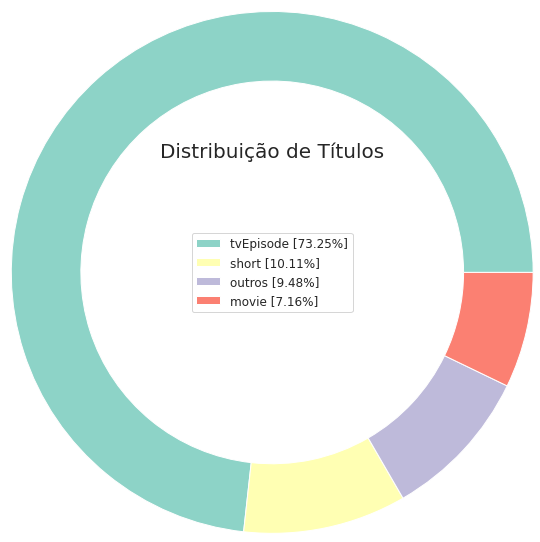

In [22]:
#Plot

#Mapa de Cores
#https://matplotlib.org/stablee/tutorials/color/colormaps.html
cs = cm.Set3(np.arange(100))
#cria a figura
f = plt.figure()
#Pie Plot
plt.pie(resultado1["COUNT"], labeldistance=1,radius=3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = "center", prop = {"size":12})
plt.title("Distribuição de Títulos", loc = "center", fontdict = {"fontsize":20, "fontweight":20})
plt.show()

## 2 - Qual o número de títulos por gênero? 

Calculando o número de filmes por gênero e entregar o resultado em valor percentual.